<a href="https://colab.research.google.com/github/sugiyama404/ReinfoceLearningForTrading/blob/main/a2c_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0-1. インストール

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime
import random
import copy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

from google.colab import drive

drive.mount('/content/drive/')
nov_dir = 'Colab Notebooks/dataset/reinforcement_learning/'
nov_path = '/content/drive/My Drive/' + nov_dir + 'sp500_test.csv'
'''
exp_dir = 'Colab Notebooks/workspace/export/'
csv_path = '/content/drive/My Drive/' + exp_dir + 'random_test.csv'
'''

df = pd.read_csv(nov_path)
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
def make_scaler(env):

  states = []
  for _ in range(env.df_total_steps):
    action = np.random.choice(env.action_space)
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
      break

  scaler = StandardScaler()
  scaler.fit(states)
  return scaler

In [3]:
class Environment:
    def __init__(self, df, initial_money=100000, mode = 'test'):

        self.df = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_money = initial_money
        self.mode = mode
        self.trade_time = None
        self.trade_win = None
        self.brfore_buy_cash = None
        self.action_space = np.array([0, 1, 2])
        self.hold_a_position = None
        self.now_price = None
        self.cash_in_hand = None

        self.reset()
        
    def reset(self):

        self.trade_time = 0
        self.trade_win = 0
        self.brfore_buy_cash = 0
        self.end_step = self.df_total_steps
        self.now_step = 0
        self.hold_a_position = 0.0
        self.now_price = self.df.loc[self.now_step, 'SP500']
        self.cash_in_hand = self.initial_money

        return self._get_now_state()

    def step(self, action):

        prev_revenue = self._get_revenue()
        self.now_step += 1
        self.now_price = self.df.loc[self.now_step, 'SP500']
 
        done = (self.end_step == self.now_step)

        self._trade(action,done)
        cur_revenue = self._get_revenue()
 
        reward = cur_revenue - prev_revenue

        if self.mode == 'test':
            info = { 'cur_revenue' : cur_revenue , 'trade_time' : self.trade_time, 'trade_win' : self.trade_win }
        else:
            info = { 'cur_revenue' : cur_revenue }

        return self._get_now_state(), reward, done, info

    def _get_now_state(self):
        state = np.empty(3)
        state[0] = self.hold_a_position
        state[1] = self.now_price
        state[2] = self.cash_in_hand
        return state

    def _get_revenue(self): 
        return self.hold_a_position * self.now_price + self.cash_in_hand

    def _trade(self, action,lastorder = False):
        if lastorder:
            self.cash_in_hand += self.now_price * self.hold_a_position
            self.hold_a_position = 0
        else:
            if self.action_space[0] == action: # sell
                if self.hold_a_position != 0:
                    self.cash_in_hand += self.now_price * self.hold_a_position
                    self.hold_a_position = 0
                    if self.mode == 'test':
                        self.trade_time += 1
                        if self.cash_in_hand > self.brfore_buy_cash:
                            self.trade_win += 1 
            if self.action_space[2] == action: # buy
                if self.hold_a_position == 0:
                    buy_flag = True
                    if self.mode == 'test':
                        self.brfore_buy_cash = copy.copy(self.cash_in_hand)
                    while buy_flag:
                        if self.cash_in_hand > self.now_price:
                            self.hold_a_position += 1
                            self.cash_in_hand -= self.now_price
                        else:
                            buy_flag = False

## 2-3. A3C/A2C

In [4]:
class Brain:
    def __init__(self,nb_actions = 3):
        # 環境の状態の形式(shape)
        obs_shape = 3

        # 環境の取りうるアクション数
        nb_actions = nb_actions

        lr = 0.01  # 学習率

        c = input_ = keras.layers.Input(shape=obs_shape)
        c = keras.layers.Dense(10, activation="relu")(c)
        c = keras.layers.Dense(10, activation="relu")(c)
        actor_layer = keras.layers.Dense(nb_actions, activation="linear")(c)
        critic_layer = keras.layers.Dense(1, activation="linear")(c)

        model = keras.Model(input_, [actor_layer, critic_layer])
        model.compile(optimizer=Adam(lr=lr))
        model.summary()
        self.model = model
    
    def predict(self, state):
        return self.model.predict(state)

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

### 行動の決定(関数)

In [5]:
def LinearSoftmaxPolicy(model, state, nb_actions):
    action_eval, _ = model(state.reshape((1,-1)))
    probs = tf.nn.softmax(action_eval)
    # 各要素が抽出される確率p
    return np.random.choice(nb_actions, 1, p=probs[0].numpy())[0]

### モデルの学習(関数)

In [6]:
def train(model, experiences):

    gamma = 0.9  # 割引率
    # 現在からエピソード最後までの報酬を計算（後ろから計算）
    if experiences[-1]["done"]:
        # 最後が終わりの場合は全部使える
        G = 0
    else:
        # 最後が終わりじゃない場合は予測値vで補完する
        next_state = np.atleast_2d(experiences[-1]["next_state"])
        _, n_v = model(next_state)
        G = n_v[0][0].numpy()

    # 割引報酬を後ろから計算
    discounted_rewards = []
    for exp in reversed(experiences):
        if exp["done"]:
            G = 0
        G = exp["reward"] + gamma * G
        discounted_rewards.append(G)
    discounted_rewards.reverse()

    # 計算用にnp化して (batch_size,1) の形にする
    discounted_rewards = np.asarray(discounted_rewards).reshape((-1, 1))
    # ベースライン処理
    discounted_rewards -= np.mean(discounted_rewards)  # 報酬の平均を引く
    # データ形式を変形
    state_batch = np.asarray([e["state"] for e in experiences])
    action_batch = np.asarray([e["action"] for e in experiences])
    # アクションをonehotベクトルの形に変形
    onehot_actions = tf.one_hot(action_batch, nb_actions)

    # 勾配を計算する
    with tf.GradientTape() as tape:

        # print(state_batch)
        action_eval, v = model(state_batch, training=True)
        #  π(a|s) を計算
        action_probs = tf.nn.softmax(action_eval)
        selected_action_probs = tf.reduce_sum(onehot_actions * action_probs, axis=1, keepdims=True)
        #--- アドバンテージを計算
        # アドバンテージ方策勾配で使うvは値として使うので、
        # 勾配で計算されないように tf.stop_gradient を使う
        advantage = discounted_rewards - tf.stop_gradient(v)
        # log(π(a|s)) * A(s,a) を計算
        selected_action_probs = tf.clip_by_value(selected_action_probs, 1e-10, 1.0)  # 0にならないようにclip
        policy_loss = tf.math.log(selected_action_probs) * advantage
        #--- Value loss
        # 平均二乗誤差で損失を計算
        value_loss = tf.reduce_mean((discounted_rewards - v) ** 2, axis=1, keepdims=True)
        #--- 方策エントロピー
        entropy = tf.reduce_sum(tf.math.log(selected_action_probs) * selected_action_probs, axis=1, keepdims=True)
        #--- batch loss
        value_loss_weight = 0.5
        entropy_weight = 0.1
        loss = -policy_loss + value_loss_weight * value_loss - entropy_weight * entropy
        # 全バッチのlossの平均(ミニバッチ処理?)
        loss = tf.reduce_mean(loss)

    # 勾配を元にoptimizerでモデルを更新
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return (loss.numpy(), np.mean(policy_loss), np.mean(value_loss), np.mean(entropy))

### 学習の実行

In [7]:
batch_size = 32
experiences = []

# 評価用関数 
metrics_history = []

episode_rewards = []

nb_actions = 3
# nb_actions = 2
brain = Brain(nb_actions)
model = brain.model

initial_money=1000000
mode = 'train'

env = Environment(df, initial_money = initial_money, mode=mode)
scaler = make_scaler(env)

for episode in range(100):
    state = env.reset()
    state = scaler.transform([state])
    state = state.flatten()
    done = False
    total_reward = 0
    episode_metrics = []
    step = 0

    # 1episode
    while not done:
        
        # アクションを決定
        action = LinearSoftmaxPolicy(model, state, nb_actions)
        # 1step進める
        next_state, reward, done, _ = env.step(action)
        next_state = scaler.transform([next_state])
        next_state = next_state.flatten()

        total_reward += reward

        # 経験を保存する
        experiences.append({"state": state, "action": action, "reward": reward, "next_state": next_state, "done": done,})

        state = next_state
        step += 1

        # batch_size貯まるごとに学習する
        if len(experiences) == batch_size:
            metrics = train(model, experiences)
            episode_metrics.append(metrics)
            experiences = []

    # ループ終了後の処理(一つのストーリー)
    # メトリクス
    if len(episode_metrics) == 0:
        metrics_history.append((None, None, None, None))
    else:
        metrics_history.append(np.mean(episode_metrics, axis=0))  # 平均を保存

    # 報酬
    episode_rewards.append(total_reward)
    print_interval = 10
    if episode % print_interval == 0:
        print("{}: {} step, reward: {} {} {}".format(
            episode, step, 
            min(episode_rewards[-print_interval:]), 
            np.mean(episode_rewards[-print_interval:]), 
            max(episode_rewards[-print_interval:])
        ))

brain.save(f'a2c_train.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           40          input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           110         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3)            33          dense_1[0][0]                    
______________________________________________________________________________________________

### 学習過程のグラフ表示

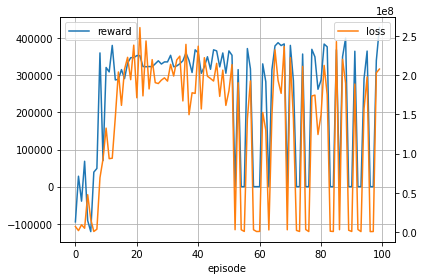

In [8]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('episode')
ax1.grid()
ax1.plot(episode_rewards, color="C0", label="reward")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot([m[0] for m in metrics_history], color="C1", label="loss")
ax2.legend(loc='upper right')

fig.tight_layout()  # レイアウトの設定
# plt.savefig('hoge.png') # 画像の保存
plt.show()

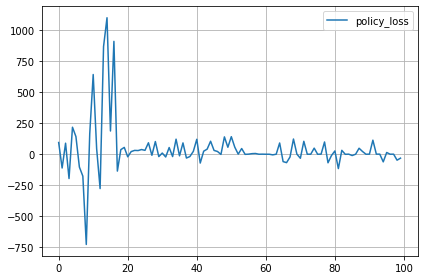

In [9]:
plt.plot([m[1] for m in metrics_history], label="policy_loss")
plt.tight_layout()  # レイアウトの設定
plt.grid()
plt.legend()
plt.show()

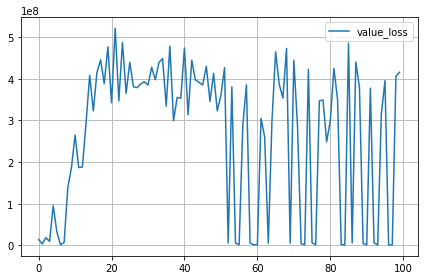

In [10]:
plt.plot([m[2] for m in metrics_history], label="value_loss")
plt.tight_layout()  # レイアウトの設定
plt.grid()
plt.legend()
plt.show()

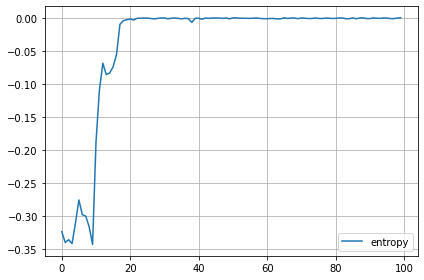

In [11]:
plt.plot([m[3] for m in metrics_history], label="entropy")
plt.tight_layout()  # レイアウトの設定
plt.grid()
plt.legend()
plt.show()